<h1> 1. Chargement des données   </h1>

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance, to_graphviz
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score   

dataset=pd.read_excel('c_fraud_transaction.xlsx')

# Dans notre nouveau dataframe on ne garde que les transactions de type 'TRANSFER' ou 'CASH_OUT'
dat=dataset.loc[(dataset.type=='TRANSFER')|(dataset.type=='CASH_OUT')].copy()
print('Le dataset, en sélectionant les colonnes \'TRANSFER\' et \'CASH_OUT\', a {} lignes et {} colonnes.'.format(dat.shape[0], dat.shape[1]))
dat=dataset.loc[(dataset.type=='TRANSFER')|(dataset.type=='CASH_OUT')].copy()
print('Le dataset, en sélectionant les colonnes \'TRANSFER\' et \'CASH_OUT\', a {} lignes et {} colonnes.'.format(dat.shape[0], dat.shape[1]))

# Transformation des valeurs de la variable type en 1 et 0, pas besoin d'utiliser le module sklearn car on peut le 
# faire directement
dat['type'] = np.where(dat['type'] == 'TRANSFER', 1, 0)
dat = dat.reset_index(drop=True)

# Supprimons les variables peu représentatives
dat.drop(['nameOrig','isFlaggedFraud','nameDest'],1,inplace=True)

"""
Les valeurs manquantes crédits on le remplace par -1 car il y avait plus des transactions frauduleuses 
qui avaient des valeurs manquantes pour les comptes crédits, cela permet à l'algorithme de differencier
"""
dat.loc[(dat.oldbalanceDest == 0) & (dat.newbalanceDest == 0) & (dat.amount != 0), \
      ['oldbalanceDest', 'newbalanceDest']] = - 1

# les valeurs manquantes debits on le remplace par 'NaN'
dat.loc[(dat.oldbalanceOrg == 0) & (dat.newbalanceOrig == 0) & (dat.amount != 0), \
      ['oldbalanceOrg', 'newbalanceOrig']] = np.nan
# les 'NaN' sont à leur tour remplacées par les valeurs medianes
dat[['oldbalanceOrg','newbalanceOrig']]=dat[['oldbalanceOrg','newbalanceOrig']].fillna(dat.median())

# Nous avons créé deux variables qui seront chacune une combinaison linéaire des deux variables corréelées
# et du montant de la transaction
d_model = pd.DataFrame(dat)
d_model['errorBalanceSender'] = d_model.oldbalanceOrg  - d_model.amount - d_model.newbalanceOrig
d_model['errorBalanceReceiver'] = d_model.oldbalanceDest + d_model.amount - d_model.newbalanceDest
d_model.drop(['oldbalanceOrg', 'oldbalanceDest'], 1, inplace=True)
d_model = d_model.rename(columns={'newbalanceOrig':'balanceSender', 'newbalanceDest':'balanceReceiver'})

# Standartiser
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# XGboost
X = d_model.iloc[:, d_model.columns !='isFraud']
y = d_model.iloc[:, 5]
clf = XGBClassifier(max_depth=7, learning_rate=0.1, n_estimators=180, objective='binary:logistic', nthread=4,
    seed=42)
clf.fit(X_train, y_train)

In [9]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance, to_graphviz
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score   

dataset=pd.read_excel('c_fraud_transaction.xlsx')

# Dans notre nouveau dataframe on ne garde que les transactions de type 'TRANSFER' ou 'CASH_OUT'
dat=dataset.loc[(dataset.type=='TRANSFER')|(dataset.type=='CASH_OUT')].copy()
print('Le dataset, en sélectionant les colonnes \'TRANSFER\' et \'CASH_OUT\', a {} lignes et {} colonnes.'.format(dat.shape[0], dat.shape[1]))
dat=dataset.loc[(dataset.type=='TRANSFER')|(dataset.type=='CASH_OUT')].copy()
print('Le dataset, en sélectionant les colonnes \'TRANSFER\' et \'CASH_OUT\', a {} lignes et {} colonnes.'.format(dat.shape[0], dat.shape[1]))

# Transformation des valeurs de la variable type en 1 et 0, pas besoin d'utiliser le module sklearn car on peut le 
# faire directement
dat['type'] = np.where(dat['type'] == 'TRANSFER', 1, 0)
dat = dat.reset_index(drop=True)

# Supprimons les variables peu représentatives
dat.drop(['nameOrig','isFlaggedFraud','nameDest'],1,inplace=True)

"""
Les valeurs manquantes crédits on le remplace par -1 car il y avait plus des transactions frauduleuses 
qui avaient des valeurs manquantes pour les comptes crédits, cela permet à l'algorithme de differencier
"""
dat.loc[(dat.oldbalanceDest == 0) & (dat.newbalanceDest == 0) & (dat.amount != 0), \
      ['oldbalanceDest', 'newbalanceDest']] = - 1

# les valeurs manquantes debits on le remplace par 'NaN'
dat.loc[(dat.oldbalanceOrg == 0) & (dat.newbalanceOrig == 0) & (dat.amount != 0), \
      ['oldbalanceOrg', 'newbalanceOrig']] = np.nan
# les 'NaN' sont à leur tour remplacées par les valeurs medianes
dat[['oldbalanceOrg','newbalanceOrig']]=dat[['oldbalanceOrg','newbalanceOrig']].fillna(dat.median())

# Nous avons créé deux variables qui seront chacune une combinaison linéaire des deux variables corréelées
# et du montant de la transaction
d_model = pd.DataFrame(dat)
d_model['errorBalanceSender'] = d_model.oldbalanceOrg  - d_model.amount - d_model.newbalanceOrig
d_model['errorBalanceReceiver'] = d_model.oldbalanceDest + d_model.amount - d_model.newbalanceDest
d_model.drop(['oldbalanceOrg', 'oldbalanceDest'], 1, inplace=True)
d_model = d_model.rename(columns={'newbalanceOrig':'balanceSender', 'newbalanceDest':'balanceReceiver'})

X = d_model.iloc[:, d_model.columns !='isFraud']
y = d_model.iloc[:, 5]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, \
                                                random_state = 0)
# Standartiser
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# XGboost
clf = XGBClassifier(max_depth=7, learning_rate=0.1, n_estimators=180, objective='binary:logistic', nthread=4,
    seed=42)
clf.fit(X_train, y_train)

Ppred = clf.predict_proba(X_test)
Ppred[1:100]

Le dataset, en sélectionant les colonnes 'TRANSFER' et 'CASH_OUT', a 10640 lignes et 11 colonnes.
Le dataset, en sélectionant les colonnes 'TRANSFER' et 'CASH_OUT', a 10640 lignes et 11 colonnes.


array([[9.99866426e-01, 1.33550217e-04],
       [9.99862790e-01, 1.37226350e-04],
       [9.99524534e-01, 4.75480250e-04],
       [9.99904513e-01, 9.55147771e-05],
       [9.98325825e-01, 1.67416024e-03],
       [6.14941120e-03, 9.93850589e-01],
       [9.99897599e-01, 1.02392667e-04],
       [9.99965429e-01, 3.45688204e-05],
       [9.99782264e-01, 2.17758992e-04],
       [9.99827325e-01, 1.72675413e-04],
       [2.70545483e-04, 9.99729455e-01],
       [9.98909593e-01, 1.09039980e-03],
       [9.90587175e-01, 9.41282045e-03],
       [9.99984503e-01, 1.55061862e-05],
       [9.99869823e-01, 1.30192857e-04],
       [9.99318659e-01, 6.81311358e-04],
       [9.99440908e-01, 5.59106295e-04],
       [9.97863054e-01, 2.13693688e-03],
       [9.99751806e-01, 2.48209515e-04],
       [9.99934733e-01, 6.52854069e-05],
       [9.99987483e-01, 1.25406232e-05],
       [9.99776423e-01, 2.23562340e-04],
       [9.99956012e-01, 4.39708565e-05],
       [5.92470169e-04, 9.99407530e-01],
       [9.998803

In [17]:
dat.head(10)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorBalanceSender,errorBalanceReceiver
0,13,0,15149.15,158857.0,143707.85,0.00,15149.15,0,0.00,0.000000e+00
1,12,0,118064.98,2709701.0,2591636.02,187337.43,305402.40,0,0.00,1.000000e-02
2,17,0,109365.10,41676.0,0.00,207150.29,520523.85,0,-67689.10,-2.040085e+05
3,22,1,116959.85,41676.0,0.00,550850.91,667810.76,0,-75283.85,0.000000e+00
4,36,0,336447.70,291.0,0.00,0.00,336447.70,0,-336156.70,0.000000e+00
5,16,0,143667.87,41676.0,0.00,2551697.83,2998386.20,0,-101991.87,-3.030205e+05
6,20,0,208956.06,51699.0,0.00,0.00,362718.60,0,-157257.06,-1.537625e+05
7,34,0,167569.45,41676.0,0.00,384409.11,551978.56,0,-125893.45,0.000000e+00
8,17,0,315870.25,113381.0,0.00,846186.86,1162057.11,0,-202489.25,-2.328306e-10
9,13,0,79811.27,41676.0,0.00,181444.32,954139.45,0,-38135.27,-6.928839e+05


In [13]:
Xt = pd.DataFrame(X_test)
Xt.loc[5:20, :]

,0,1,2,3,4,5,6
5,-0.651928,-0.54005,-0.398438,0.655644,-0.397392,0.596354,0.013529
6,-0.706938,1.85168,-0.404853,-0.123090,-0.207254,0.596317,0.013529
7,-0.541907,-0.54005,-0.238334,-0.123090,-0.056086,0.035332,0.013529
8,-0.871969,-0.54005,-0.240849,-0.123090,-0.114475,0.137612,0.013529
9,-1.092009,-0.54005,-0.136114,-0.123090,-0.359259,-0.188878,0.051431
10,0.668317,1.85168,-0.230645,-0.123090,2.400519,0.146680,0.013529
11,2.043572,-0.54005,8.357120,-0.123090,1.950738,0.596354,0.013529
12,-1.092009,-0.54005,-0.129832,-0.123090,-0.472763,0.184647,-0.172161
13,0.338256,-0.54005,-0.325943,-0.123090,-0.456482,0.392647,0.013529
14,-0.706938,-0.54005,-0.234165,-0.123090,-0.334008,0.155766,0.013529


In [ ]:
itération sur l'ensemble des lignes du dataframe, affichache de l'index et son commentaire associé
for index, row in Xf.iterrows():
    print('index: ', index, 'col sentences:', row['bons_points'])

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance, to_graphviz
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score   

dataset=pd.read_excel('c_fraud_transaction.xlsx')

# Dans notre nouveau dataframe on ne garde que les transactions de type 'TRANSFER' ou 'CASH_OUT'
dat=dataset.loc[(dataset.type=='TRANSFER')|(dataset.type=='CASH_OUT')].copy()
print('Le dataset, en sélectionant les colonnes \'TRANSFER\' et \'CASH_OUT\', a {} lignes et {} colonnes.'.format(dat.shape[0], dat.shape[1]))
dat=dataset.loc[(dataset.type=='TRANSFER')|(dataset.type=='CASH_OUT')].copy()
print('Le dataset, en sélectionant les colonnes \'TRANSFER\' et \'CASH_OUT\', a {} lignes et {} colonnes.'.format(dat.shape[0], dat.shape[1]))

# Transformation des valeurs de la variable type en 1 et 0, pas besoin d'utiliser le module sklearn car on peut le 
# faire directement
dat['type'] = np.where(dat['type'] == 'TRANSFER', 1, 0)
dat = dat.reset_index(drop=True)

# Supprimons les variables peu représentatives
dat.drop(['nameOrig','isFlaggedFraud','nameDest'],1,inplace=True)

"""
Les valeurs manquantes crédits on le remplace par -1 car il y avait plus des transactions frauduleuses 
qui avaient des valeurs manquantes pour les comptes crédits, cela permet à l'algorithme de differencier
"""
dat.loc[(dat.oldbalanceDest == 0) & (dat.newbalanceDest == 0) & (dat.amount != 0), \
      ['oldbalanceDest', 'newbalanceDest']] = - 1

# les valeurs manquantes debits on le remplace par 'NaN'
dat.loc[(dat.oldbalanceOrg == 0) & (dat.newbalanceOrig == 0) & (dat.amount != 0), \
      ['oldbalanceOrg', 'newbalanceOrig']] = np.nan
# les 'NaN' sont à leur tour remplacées par les valeurs medianes
dat[['oldbalanceOrg','newbalanceOrig']]=dat[['oldbalanceOrg','newbalanceOrig']].fillna(dat.median())

# Nous avons créé deux variables qui seront chacune une combinaison linéaire des deux variables corréelées
# et du montant de la transaction
d_model = pd.DataFrame(dat)
d_model['errorBalanceSender'] = d_model.oldbalanceOrg  - d_model.amount - d_model.newbalanceOrig
d_model['errorBalanceReceiver'] = d_model.oldbalanceDest + d_model.amount - d_model.newbalanceDest
d_model.drop(['oldbalanceOrg', 'oldbalanceDest'], 1, inplace=True)
d_model = d_model.rename(columns={'newbalanceOrig':'balanceSender', 'newbalanceDest':'balanceReceiver'})

# Standartiser
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# XGboost
X = d_model.iloc[:, d_model.columns !='isFraud']
y = d_model.iloc[:, 5]
clf = XGBClassifier(max_depth=7, learning_rate=0.1, n_estimators=180, objective='binary:logistic', nthread=4,
    seed=42)
clf_fit = clf.fit(X_train, y_train)

# Faire une prédiction de la probabilité p(Y =1) à l'aide de la fonction .predict_proba()
pred = clf_fit.predict_proba(X_test)

Populating the interactive namespace from numpy and matplotlib


In [118]:
""" Transformation des valeurs de la variable type en 1 et 0 pas besoin d'utiliser le module sklearn car on peut le 
faire directement """
dat['type'] = np.where(dat['type'] == 'TRANSFER', 1, 0)
dat = dat.reset_index(drop=True)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,8,0,140116.48,C1975423113,0.00,0.0,C66893623,247156.54,532921.62,0,0
1,32,1,2023920.09,C306405849,2023920.09,0.0,C193080093,0.00,0.00,1,0
2,94,0,299919.71,C730376461,0.00,0.0,C872848343,694805.84,994725.55,0,0
3,13,0,249045.05,C427440835,13635.12,0.0,C853781603,289461.64,538506.68,0,0
4,44,0,309904.46,C940965545,0.00,0.0,C1030111655,343438.71,952164.98,0,0


In [119]:
# supprimons les variables peu représentatives
dat.drop(['nameOrig','isFlaggedFraud','nameDest'],1,inplace=True)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,8,0,140116.48,0.00,0.0,247156.54,532921.62,0
1,32,1,2023920.09,2023920.09,0.0,0.00,0.00,1
2,94,0,299919.71,0.00,0.0,694805.84,994725.55,0
3,13,0,249045.05,13635.12,0.0,289461.64,538506.68,0
4,44,0,309904.46,0.00,0.0,343438.71,952164.98,0


In [130]:
"""
Les valeurs manquantes crédits on le remplace par -1 car il y avait plus des transactions frauduleuses qui avaient des valeurs 
manquantes pour les comptes crédits, cela permet à l'algorithme de differencier
"""
dat.loc[(dat.oldbalanceDest == 0) & (dat.newbalanceDest == 0) & (dat.amount != 0), \
      ['oldbalanceDest', 'newbalanceDest']] = - 1

In [131]:
# les valeurs manquantes debits on le remplace par 'NaN'
dat.loc[(dat.oldbalanceOrg == 0) & (dat.newbalanceOrig == 0) & (dat.amount != 0), \
      ['oldbalanceOrg', 'newbalanceOrig']] = np.nan
# les 'NaN' sont à leur tour remplacées par les valeurs medianes
dat[['oldbalanceOrg','newbalanceOrig']]=dat[['oldbalanceOrg','newbalanceOrig']].fillna(dat.median())

In [134]:
d_model=pd.DataFrame(dat)
d_model['errorBalanceSender'] = d_model.oldbalanceOrg  - d_model.amount - d_model.newbalanceOrig
d_model['errorBalanceReceiver'] = d_model.oldbalanceDest + d_model.amount - d_model.newbalanceDest
d_model.drop(['oldbalanceOrg', 'oldbalanceDest'], 1, inplace=True)
d_model = d_model.rename(columns={'newbalanceOrig':'balanceSender', 'newbalanceDest':'balanceReceiver'})

,step,type,amount,balanceSender,balanceReceiver,isFraud,errorBalanceSender,errorBalanceReceiver
0,8,0,140116.48,0.0,532921.62,0,-98440.48,-145648.60
1,32,1,2023920.09,0.0,-1.00,1,0.00,2023920.09
2,94,0,299919.71,0.0,994725.55,0,-258243.71,0.00
3,13,0,249045.05,0.0,538506.68,0,-235409.93,0.01
4,44,0,309904.46,0.0,952164.98,0,-268228.46,-298821.81


In [148]:
# y variable dépendante et X variables indépendantes
X = d_model.iloc[:, d_model.columns !='isFraud'].values
y = d_model.iloc[:, 5].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [149]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

(8512, 7) (8512,)
(2128, 7) (2128,)


In [150]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

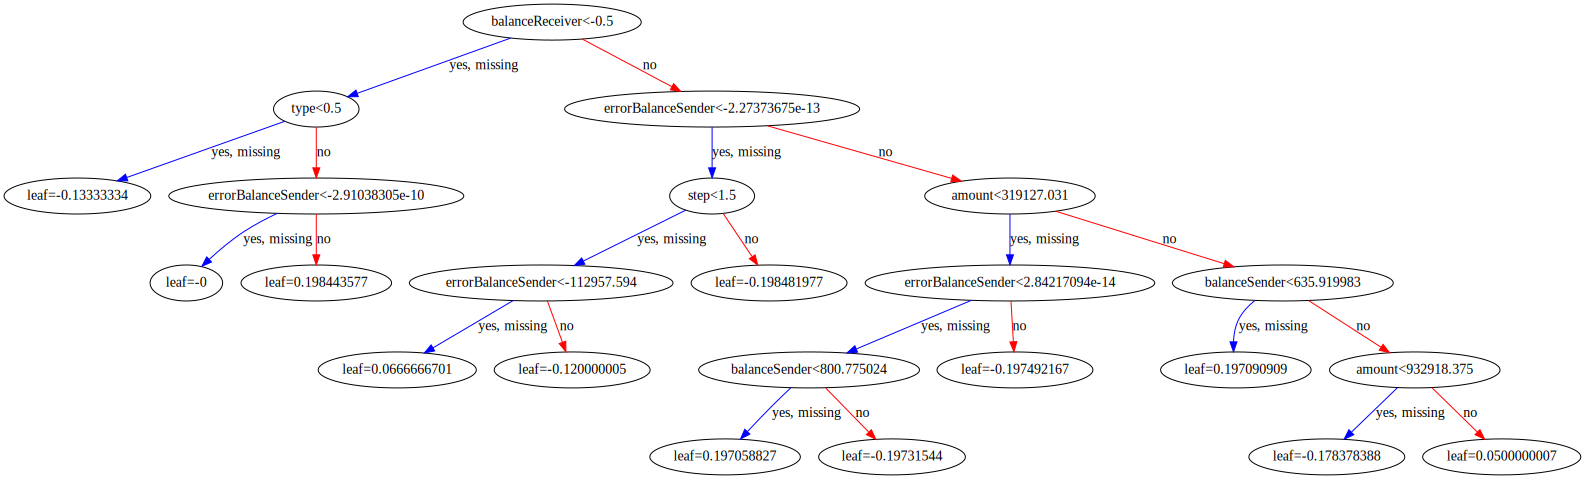

In [161]:
# y variable dépendante et X variables indépendantes
X = d_model.iloc[:, d_model.columns !='isFraud']
y = d_model.iloc[:, 5]
trainX, testX, trainY, testY = train_test_split(X, y, test_size = 0.2, \
                                                random_state = 0)
clf = XGBClassifier(max_depth=7, learning_rate=0.1, n_estimators=180, objective='binary:logistic', nthread=4,
    seed=42)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)